###LIBRARIES



In [ ]:
 !pip install -q pyLDAvis==2.1.2

In [ ]:
# Don't print warnings
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
import bz2
import re
import os
import gc
import nltk
from nltk.corpus import stopwords
import joblib
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from sklearn.metrics import (precision_recall_curve, auc, confusion_matrix,
                             f1_score, fbeta_score, precision_score,
                             recall_score, classification_report)
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
import pickle
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import random
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###IMPORT THE DATA


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_file = bz2.BZ2File('/content/drive/MyDrive/text_mining/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/drive/MyDrive/text_mining/test.ft.txt.bz2')

In [ ]:
type(train_file)

bz2.BZ2File

In [ ]:
type(test_file)

bz2.BZ2File

In [ ]:
def load_extract(file):
    texts, labels = [], [] 
    for line in file:
        x = line.decode('utf-8')  # decode binary to string
        labels.append(int(x[9]) - 1)  # extract labels
        texts.append(x[10:].strip())  # extract texts
    print('finish')
    return np.array(labels), texts


In [ ]:
train_labels, train_texts = load_extract(train_file)
test_labels, test_texts = load_extract(test_file)

finish
finish


In [ ]:
train_texts[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [ ]:
train_labels[0]

1

###PRE-PROCESSING

In [ ]:
def clean_texts(texts):
    stwords = stopwords.words('english')
    l = len(texts)/10
    temp_texts = []
    for i in range(len(texts)):
        text = re.sub('\d','0',texts[i])
        if 'www.' in text or 'http:' in text or 'https:' in text or '.com' in text: # remove links and urls
            text = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", " ", text)
        
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        text = text.split() #tokenization
        text = [word for word in text if not word in stwords]
        text = ' '.join(text)
        temp_texts.append(text)
        if i%l==0:
            print('--'+str(int(i/l)*10)+'%', end='')
    print('Finishd all')
    return temp_texts

In [ ]:
print('Processing Training data')
train_texts = clean_texts(train_texts)
print('\nProcessing Test data')
test_texts = clean_texts(test_texts)

Processing Training data
--0%--10%--20%--30%--40%--50%--60%--70%--80%--90%Finishd all

Processing Test data
--0%--10%--20%--30%--40%--50%--60%--70%--80%--90%Finishd all


###SAVING PREPROCESSED TEXT AND LABELS 

In [ ]:
#save your model or results
#joblib.dump(train_texts, '/content/drive/MyDrive/text_mining/traintext_preprocessed')
#joblib.dump(train_labels, '/content/drive/MyDrive/text_mining/train_labels')
#joblib.dump(test_texts, '/content/drive/MyDrive/text_mining/testtext_preprocessed')
#joblib.dump(test_labels, '/content/drive/MyDrive/text_mining/testlabels')


In [ ]:
train_T = joblib.load('/content/drive/MyDrive/text_mining/traintext_preprocessed')
test_t = joblib.load('/content/drive/MyDrive/text_mining/testtext_preprocessed')



In [ ]:
len(train_T)

3600000

In [ ]:
train_T[1], train_L[1]

('best soundtrack ever anything reading lot reviews saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening years beauty simply refuses fade price tag pretty staggering must say going buy cd much money one feel would worth every penny',
 1)

In [ ]:
len(test_t)

400000

In [ ]:
train_L = joblib.load('/content/drive/MyDrive/text_mining/train_labels')
test_l = joblib.load('/content/drive/MyDrive/text_mining/testlabels')

In [ ]:
train_T[0]

'stuning even non gamer sound track beautiful paints senery mind well would recomend even people hate vid game music played game chrono cross games ever played best music backs away crude keyboarding takes fresher step grate guitars soulful orchestras would impress anyone cares listen'

In [ ]:
train_L[0]

1

###SAMPLING DATA


In [ ]:
train_t, _, train_l, _ = train_test_split(train_T, train_L, test_size=0.98, random_state = 42, shuffle = True, stratify = train_L) #reduce train dimensionality without imbalance classes

In [ ]:
train_text, test_text , train_labels, test_labels = train_test_split(train_t, train_l, test_size=0.3, random_state = 42, shuffle = True, stratify = train_l) #splitting the sampling of the original into train and test 

####SAVE SAMPLED DATA


In [ ]:
#joblib.dump(train_text, '/content/drive/MyDrive/text_mining/traintext_preprocessed_sampled')
#joblib.dump(train_labels, '/content/drive/MyDrive/text_mining/trainlabels_preprocessed_sampled')
#joblib.dump(test_text, '/content/drive/MyDrive/text_mining/testtext_preprocessed_sampled')
#joblib.dump(test_labels, '/content/drive/MyDrive/text_mining/testlabels_preprocessed_sampled')


['/content/drive/MyDrive/text_mining/testlabels_preprocessed_sampled']

In [ ]:
train_text = joblib.load('/content/drive/MyDrive/text_mining/traintext_preprocessed_sampled')
test_text = joblib.load('/content/drive/MyDrive/text_mining/testtext_preprocessed_sampled')

In [ ]:
train_labels = joblib.load('/content/drive/MyDrive/text_mining/trainlabels_preprocessed_sampled')
test_labels = joblib.load('/content/drive/MyDrive/text_mining/testlabels_preprocessed_sampled')

###EXPLORATORY DATA ANALYSIS 


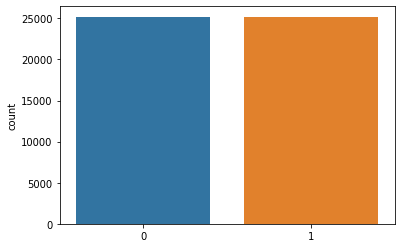

In [ ]:
sns.countplot(x=train_labels)

In [ ]:
train_labels.size

50400

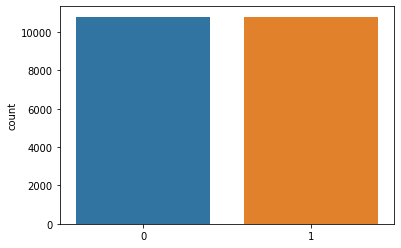

In [ ]:
sns.countplot(x=test_labels)

In [ ]:
test_labels.size

21600

In [ ]:
count_z = (train_labels == 0).sum()
count_o = (train_labels == 1).sum()

print('0 occurences in train labels: ', count_z)
print('1 occurences in train labels: ', count_o)



0 occurences in train labels:  25200
1 occurences in train labels:  25200


The data are perfectly balanced

In [ ]:
len(train_text)

50400

In [ ]:
train_text[1], train_labels[1]

('good beginning careful effective thought might good idea post warning instance exercise create empower astral entity take attributes one shortcomings could extremely dangerous experience much difficult banish energy form trouble many magicians working forces cannot see distinct disadvantage forces decide take advantage suggest magical student practice protection intuitive techniques performing entity creating invoking exercises accomplished magician protection need also recommended hands light barbara brennan way shaman michael harner excellent beginning perceive work subtle energies shamanic work root magical practices',
 1)

In [ ]:
test_text[1], test_labels[1]

('julie garwood still one fav authors series reviewed another look book reviewsif first time considering julie garwood book pass select one historicals generally star reviews book admit disappointed adam story maybe disappointed strong word genevieve drove nuts really stand nonsense seemed smart brave one moment plain stupid next nothing hate stupid heroine makes stupid decisions storyline one red rose draw fact made decision read next book series awhile rose books grabbed way julie garwood books usually memorize sure fallen love series clayborne men outstanding feel series',
 0)

###TEXT RAPRESENTATION

####tf-idf

In [ ]:
tfidf_vect = TfidfVectorizer(min_df=5, max_features=500)
X_train_tfidf = tfidf_vect.fit_transform(train_text)

In [ ]:
X_train_tfidf.shape

(50400, 500)

In [ ]:
X_test_tfidf = tfidf_vect.transform(test_text)

In [ ]:
X_test_tfidf.shape

(21600, 500)

####doc2vec

In [ ]:
# Uniamo le due liste di recensioni
all_text = train_text + test_text

In [ ]:
# Mischiamo le recensioni
random.shuffle(all_text)

In [ ]:
tagged_reviews = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(all_text)]

In [ ]:
d2v = Doc2Vec(tagged_reviews, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# generare gli embedding per i dati di valutazione
X_test_d2v = [d2v.infer_vector(review.split()) for review in test_text]

In [ ]:
X_train_d2v = [d2v.infer_vector(review.split()) for review in train_text]

####LOAD OF TF IDF

In [ ]:
#sparse.save_npz("/content/drive/MyDrive/text_mining/train_preprocessed_tfidf.npz",X_train_tfidf)
#sparse.save_npz("/content/drive/MyDrive/text_mining/test_preprocessed_tfidf.npz",X_test_tfidf)

In [ ]:
X_train_tfidf = sparse.load_npz("/content/drive/MyDrive/text_mining/train_preprocessed_tfidf.npz")
X_test_tfidf = sparse.load_npz("/content/drive/MyDrive/text_mining/test_preprocessed_tfidf.npz")

####LOAD OF DOC2VEC

In [ ]:
#with open("/content/drive/MyDrive/text_mining/train_preprocessed_d2v.pickle", 'wb') as handle:
    #pickle.dump(X_train_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open("/content/drive/MyDrive/text_mining/test_preprocessed_d2v.pickle", 'wb') as handle:
    #pickle.dump(X_test_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load train data
with open('/content/drive/MyDrive/text_mining/train_preprocessed_d2v.pickle', 'rb') as handle:
    X_train_d2v = pickle.load(handle)

# Load test data
with open('/content/drive/MyDrive/text_mining/test_preprocessed_d2v.pickle', 'rb') as handle:
    X_test_d2v = pickle.load(handle)

###TEXT CLASSIFICATION

In [ ]:
def score_model(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy

    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, beta=2) # F2
    cm = confusion_matrix(y_test, predictions)
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "Test F1", "Test F2"]

    scores = [train_score, test_score, prec, rec, f1, f2]

    print(("{:20s} {:.5f}\n"*6)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    print("Classification report:")
    print(classification_report(y_test, predictions, digits=5))

####TF-IDF

#####Logistic Regression

In [ ]:
lr = LogisticRegression(n_jobs=-1, max_iter=150)
lr.fit(X_train_tfidf, train_labels)

LogisticRegression(max_iter=150, n_jobs=-1)

In [ ]:
y_pred_lr = lr.predict(X_test_tfidf)

In [ ]:
score_model(lr, X_train_tfidf, X_test_tfidf, train_labels, test_labels)

Train Accuracy       0.84083
Test Accuracy        0.83375
Test Precision       0.83465
Test Recall          0.83241
Test F1              0.83353
Test F2              0.83285
Classification report:
              precision    recall  f1-score   support

           0    0.83286   0.83509   0.83397     10800
           1    0.83465   0.83241   0.83353     10800

    accuracy                        0.83375     21600
   macro avg    0.83375   0.83375   0.83375     21600
weighted avg    0.83375   0.83375   0.83375     21600



#####Support Vector Machine (Best model for tf-idf text rapresentation)

In [ ]:
svm = SVC(kernel='linear')

In [ ]:
svm.fit(X_train_tfidf, train_labels) #troppo oneroso 8 ore per il training prima di crashare

SVC(kernel='linear')

In [ ]:
y_pred_best_tfidf = svm.predict(X_test_tfidf)

In [ ]:
len(y_pred_best_tfidf)

21600

In [ ]:
score_model(svm, X_train_tfidf, X_test_tfidf, train_labels, test_labels)

Train Accuracy       0.84113
Test Accuracy        0.83486
Test Precision       0.83834
Test Recall          0.82972
Test F1              0.83401
Test F2              0.83143
Classification report:
              precision    recall  f1-score   support

           0    0.83145   0.84000   0.83571     10800
           1    0.83834   0.82972   0.83401     10800

    accuracy                        0.83486     21600
   macro avg    0.83490   0.83486   0.83486     21600
weighted avg    0.83490   0.83486   0.83486     21600



#####RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(n_estimators = 72,max_depth = 20, n_jobs=-1, random_state = 0)

In [ ]:
rf.fit(X_train_tfidf, train_labels)

RandomForestClassifier(max_depth=20, n_estimators=72, n_jobs=-1, random_state=0)

In [ ]:
y_pred_rf = rf.predict(X_test_tfidf)

In [ ]:
score_model(rf, X_train_tfidf, X_test_tfidf, train_labels, test_labels) 

Train Accuracy       0.85405
Test Accuracy        0.80282
Test Precision       0.81228
Test Recall          0.78769
Test F1              0.79979
Test F2              0.79248
Classification report:
              precision    recall  f1-score   support

           0    0.79392   0.81796   0.80576     10800
           1    0.81228   0.78769   0.79979     10800

    accuracy                        0.80282     21600
   macro avg    0.80310   0.80282   0.80278     21600
weighted avg    0.80310   0.80282   0.80278     21600



#####NEURAL NETWORK


In [ ]:
np.random.seed(1337)
nb_classes = 20
batch_size = 128
nb_epochs = 5

In [ ]:
X = X_train_tfidf.astype('float16')

In [ ]:
X_test = X_test_tfidf.astype('float16')

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)

<ipython-input-15-87a684a0c8a4>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)


In [ ]:
estimator.fit(X, train_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               128256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               51400     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 160)               32160     
                                                                 
 dropout_2 (Dropout)         (None, 160)               0         
                                                                 
 dense_3 (Dense)             (None, 120)               1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


394/394 [==============================] - 7s 13ms/step - loss: 0.4418 - accuracy: 0.7847
Epoch 2/15
394/394 [==============================] - 5s 13ms/step - loss: 0.3663 - accuracy: 0.8398
Epoch 3/15
394/394 [==============================] - 5s 13ms/step - loss: 0.3394 - accuracy: 0.8534
Epoch 4/15
394/394 [==============================] - 5s 13ms/step - loss: 0.3067 - accuracy: 0.8720
Epoch 5/15
394/394 [==============================] - 5s 13ms/step - loss: 0.2652 - accuracy: 0.8908
Epoch 6/15
394/394 [==============================] - 5s 13ms/step - loss: 0.2215 - accuracy: 0.9107
Epoch 7/15
394/394 [==============================] - 6s 14ms/step - loss: 0.1886 - accuracy: 0.9249
Epoch 8/15
394/394 [==============================] - 6s 14ms/step - loss: 0.1581 - accuracy: 0.9382
Epoch 9/15
394/394 [==============================] - 5s 14ms/step - loss: 0.1379 - accuracy: 0.9460
Epoch 10/15
394/394 [==============================] - 5s 13ms/step - loss: 0.1188 - accuracy: 0.9537


In [ ]:
score_model(estimator, X, X_test, train_labels, test_labels) 

675/675 [==============================] - 2s 2ms/step
Train Accuracy       0.99657
Test Accuracy        0.82273
Test Precision       0.81951
Test Recall          0.82778
Test F1              0.82362
Test F2              0.82611
Classification report:
              precision    recall  f1-score   support

           0    0.82602   0.81769   0.82183     10800
           1    0.81951   0.82778   0.82362     10800

    accuracy                        0.82273     21600
   macro avg    0.82276   0.82273   0.82273     21600
weighted avg    0.82276   0.82273   0.82273     21600



####Doc2Vec

#####Logistic Regression

In [ ]:
lr = LogisticRegression(n_jobs=-1, max_iter=150)
lr.fit(X_train_d2v, train_labels)

LogisticRegression(max_iter=150, n_jobs=-1)

In [ ]:
y_pred_lr = lr.predict(X_test_d2v)

In [ ]:
score_model(lr, X_train_d2v, X_test_d2v, train_labels, test_labels)

Train Accuracy       0.79105
Test Accuracy        0.79417
Test Precision       0.79088
Test Recall          0.79981
Test F1              0.79532
Test F2              0.79801
Classification report:
              precision    recall  f1-score   support

           0    0.79753   0.78852   0.79300     10800
           1    0.79088   0.79981   0.79532     10800

    accuracy                        0.79417     21600
   macro avg    0.79420   0.79417   0.79416     21600
weighted avg    0.79420   0.79417   0.79416     21600



#####Support Vector Machine

In [ ]:
svm = SVC(kernel='linear')

In [ ]:
svm.fit(X_train_d2v, train_labels) #troppo oneroso 8 ore per il training prima di crashare

SVC(kernel='linear')

In [ ]:
y_pred_svm = svm.predict(X_test_d2v)

In [ ]:
score_model(svm, X_train_d2v, X_test_d2v, train_labels, test_labels)

Train Accuracy       0.79218
Test Accuracy        0.79454
Test Precision       0.79003
Test Recall          0.80231
Test F1              0.79612
Test F2              0.79983
Classification report:
              precision    recall  f1-score   support

           0    0.79919   0.78676   0.79293     10800
           1    0.79003   0.80231   0.79612     10800

    accuracy                        0.79454     21600
   macro avg    0.79461   0.79454   0.79452     21600
weighted avg    0.79461   0.79454   0.79452     21600



#####Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 72,max_depth = 20, n_jobs=-1, random_state = 0)

In [ ]:
rf.fit(X_train_d2v, train_labels)

RandomForestClassifier(max_depth=20, n_estimators=72, n_jobs=-1, random_state=0)

In [ ]:
y_pred_rf = rf.predict(X_test_d2v)

In [ ]:
score_model(rf, X_train_d2v, X_test_d2v, train_labels, test_labels) 

Train Accuracy       0.99990
Test Accuracy        0.76435
Test Precision       0.76995
Test Recall          0.75398
Test F1              0.76188
Test F2              0.75712
Classification report:
              precision    recall  f1-score   support

           0    0.75898   0.77472   0.76677     10800
           1    0.76995   0.75398   0.76188     10800

    accuracy                        0.76435     21600
   macro avg    0.76447   0.76435   0.76433     21600
weighted avg    0.76447   0.76435   0.76433     21600



#####NEURAL NETWORK (best model for Doc2Vec text rapresentation)

In [ ]:
import numpy as np

# converti i dati del vettore in un array numpy
X_tr_d2v = np.asarray(X_train_d2v)

# cambia il tipo di dati dell'array in float16
doc2vec_data = X_tr_d2v.astype(np.float16)

In [ ]:
# converti i dati del vettore in un array numpy
X_te_d2v = np.asarray(X_test_d2v)

# cambia il tipo di dati dell'array in float16
doc2vec_test_data = X_te_d2v.astype(np.float16)

In [ ]:
np.random.seed(1337)
nb_classes = 20
batch_size = 128
nb_epochs = 5

In [ ]:
#del model

def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)

<ipython-input-28-87a684a0c8a4>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)


In [ ]:
estimator.fit(doc2vec_data, train_labels)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               25856     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 200)               51400     
                                                                 
 dropout_11 (Dropout)        (None, 200)               0         
                                                                 
 dense_14 (Dense)            (None, 160)               32160     
                                                                 
 dropout_12 (Dropout)        (None, 160)               0         
                                                                 
 dense_15 (Dense)            (None, 120)              

In [ ]:
y_pred_best_d2v = estimator.predict(doc2vec_test_data)

675/675 [==============================] - 1s 2ms/step


In [ ]:
len(y_pred_best_d2v)

21600

In [ ]:
len(doc2vec_test_data)

21600

In [ ]:
score_model(estimator, doc2vec_data, doc2vec_test_data, train_labels, test_labels) 

675/675 [==============================] - 1s 2ms/step
Train Accuracy       0.84863
Test Accuracy        0.80250
Test Precision       0.80189
Test Recall          0.80352
Test F1              0.80270
Test F2              0.80319
Classification report:
              precision    recall  f1-score   support

           0    0.80312   0.80148   0.80230     10800
           1    0.80189   0.80352   0.80270     10800

    accuracy                        0.80250     21600
   macro avg    0.80250   0.80250   0.80250     21600
weighted avg    0.80250   0.80250   0.80250     21600



###CREATION OF DATASET FOR TOPIC MODELLING

####TFIDF DATASET

In [ ]:
type(y_pred_best_tfidf)

numpy.ndarray

In [ ]:
type(test_text)

list

In [ ]:
data = {'test_text': test_text, 'value': y_pred_best_tfidf}
df_tfidf = pd.DataFrame(data)

In [ ]:
df_tfidf.head()

,test_text,value
0,potential disappointment saw lucy lui antonio ...,0
1,julie garwood still one fav authors series rev...,0
2,end metaphysics indeed heidegger bends neitzch...,0
3,different good way opinion cd good shows ashan...,1
4,expected strings goodness sake players love em...,1


####DOC2VEC DATASET

In [ ]:
type(y_pred_best_d2v)

numpy.ndarray

In [ ]:
type(test_text)

list

In [ ]:
d = {'test_text': test_text, 'value': y_pred_best_d2v}
df_d2v = pd.DataFrame(d)

####save and load the dataset

In [ ]:
#df_tfidf.to_csv('/content/drive/MyDrive/text_mining/df_tfidf.csv')

In [ ]:
#df_d2v.to_csv('/content/drive/MyDrive/text_mining/df_d2v.csv')

In [ ]:
df_tfidf = pd.read_csv('/content/drive/MyDrive/text_mining/df_tfidf.csv')

In [ ]:
df_d2v = pd.read_csv('/content/drive/MyDrive/text_mining/df_d2v.csv')

In [ ]:
df_tfidf= df_tfidf.drop(columns=["Unnamed: 0"])

In [ ]:
df_d2v = df_d2v.drop(columns=["Unnamed: 0"])

In [ ]:
df_tfidf.head()

,test_text,value
0,potential disappointment saw lucy lui antonio ...,0
1,julie garwood still one fav authors series rev...,0
2,end metaphysics indeed heidegger bends neitzch...,0
3,different good way opinion cd good shows ashan...,1
4,expected strings goodness sake players love em...,1


In [ ]:
# creo la sottoporzione di dataset con value == 0
tfidf_value_0 = df_tfidf.loc[df_tfidf["value"] == 0]

In [ ]:
tfidf_value_0.head()

,test_text,value
0,potential disappointment saw lucy lui antonio ...,0
1,julie garwood still one fav authors series rev...,0
2,end metaphysics indeed heidegger bends neitzch...,0
5,hate g rated movies would movie name ice princ...,0
9,buy toaster update month toaster stopped poppi...,0


In [ ]:
# creo la sottoporzione di dataset con value == 1
tfidf_value_1 = df_tfidf.loc[df_tfidf["value"] == 1]

In [ ]:
tfidf_value_1.head()

,test_text,value
3,different good way opinion cd good shows ashan...,1
4,expected strings goodness sake players love em...,1
6,aircraft profile volume relates concise detail...,1
7,excellent buy crib wonderful crib ever sturdy ...,1
8,great songs wonderful singer clay aiken defina...,1


In [ ]:
df_d2v.head()

,test_text,value
0,potential disappointment saw lucy lui antonio ...,0
1,julie garwood still one fav authors series rev...,0
2,end metaphysics indeed heidegger bends neitzch...,1
3,different good way opinion cd good shows ashan...,1
4,expected strings goodness sake players love em...,1


In [ ]:
# creo la sottoporzione di dataset con value == 0
d2v_value_0 = df_d2v.loc[df_d2v["value"] == 0]

In [ ]:
d2v_value_0.head()

,test_text,value
0,potential disappointment saw lucy lui antonio ...,0
1,julie garwood still one fav authors series rev...,0
5,hate g rated movies would movie name ice princ...,0
9,buy toaster update month toaster stopped poppi...,0
10,like dance hits one keeper unfortunately many ...,0


In [ ]:
# creo la sottoporzione di dataset con value == 1
d2v_value_1 = df_d2v.loc[df_d2v["value"] == 1]

In [ ]:
d2v_value_1.head()

,test_text,value
2,end metaphysics indeed heidegger bends neitzch...,1
3,different good way opinion cd good shows ashan...,1
4,expected strings goodness sake players love em...,1
6,aircraft profile volume relates concise detail...,1
7,excellent buy crib wonderful crib ever sturdy ...,1


###TOPIC MODELING


In [ ]:
tfidf_0 = tfidf_value_0['test_text']

In [ ]:
l_0 = tfidf_0.tolist() 

In [ ]:
tfidf_1 = tfidf_value_1['test_text']

In [ ]:
l_1 = tfidf_1.tolist() 

####GENSIM TOPIC MODELING

#####tf-idf

######recensioni classificate come negative

In [ ]:
size = len(l_0)

In [ ]:
text=[]
for x in range(0,size):
  text.append(list(l_0[x].split()))

In [ ]:
doc_id = 0
l_0[doc_id]

'potential disappointment saw lucy lui antonio banderas going action film together excited actors high list quality artists imagine dismay watched movie realized horribly plotted poorly constructed bomb banderas ecks lui sever one dimensional robots screen dialogue forced action scenes thrown time time liven things plot weak best even bad guy miscast unconvincing unless diehard fan either lui banderas avoid wasting time sitting movie beginning end bad'

In [ ]:
text[doc_id][:5]

['potential', 'disappointment', 'saw', 'lucy', 'lui']

In [ ]:
dictionary = Dictionary(text)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
dictionary[549]

'cd'

In [ ]:
dictionary[0]

'action'

In [ ]:
corpus = [dictionary.doc2bow(i) for i in text]

In [ ]:
[(dictionary[k], v) for k, v in corpus[0][:5]]

[('action', 2), ('actors', 1), ('artists', 1), ('avoid', 1), ('bad', 2)]

In [ ]:
lda_gensim_tf_idf0 = LdaModel(corpus, num_topics=8, id2word=dictionary,  random_state=28)

In [ ]:
pyLDAvis.gensim.prepare(lda_gensim_tf_idf0, corpus, dictionary, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  26.440093
0      186.487061  -98.103249       2        1  18.343510
4       19.245832  160.858780       3        1  14.241404
7      170.658829   75.445076       4        1  10.588887
1       -1.386411  -35.043739       5        1   8.717007
6     -145.800095  106.944611       6        1   8.047467
2       64.834541 -221.825272       7        1   7.156111
3     -196.906036  -58.990913       8        1   6.465521, topic_info=          Term         Freq        Total Category  logprob  loglift
55        book  5358.000000  5358.000000  Default  30.0000  30.0000
29       movie  1868.000000  1868.000000  Default  29.0000  29.0000
220    product  1803.000000  1803.000000  Default  28.0000  28.0000
1031       dvd   835.000000   835.000000  Default  27.0000  27.0000
1579      game   807.000000   807.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
597   original    67.777043   414.500173   Topic8  -5.9391   0.9278
549         cd    77.071368   843.452781   Topic8  -5.8106   0.3459
52     another    77.214542   867.998636   Topic8  -5.8088   0.3191
89      really    86.252609  1712.634554   Topic8  -5.6981  -0.2498
422       make    77.352343   989.793032   Topic8  -5.8070   0.1896

[703 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1271      1  0.112213  acting
1271      2  0.367243  acting
1271      3  0.010201  acting
1271      4  0.484557  acting
1271      5  0.005101  acting
...     ...       ...     ...
4333      6  0.051833    yoga
5980      4  0.949186     yrs
5980      6  0.043145     yrs
3686      8  0.917897   zelda
5183      6  0.973441  zombie

[2065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 8, 2, 7, 3, 4])

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_gensim_tf_idf0, texts=text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.43279334546180803


In [ ]:
#stampo per ogni topic identificato una coppia rappresentante una parola (rappresentante il topic) e peso della parola nel topic
topics_tfidf_0 = lda_gensim_tf_idf0.show_topics(num_topics=8, num_words=5, formatted=False)
for topic in topics_tfidf_0:
  print(topic)

(0, [('one', 0.01165053), ('like', 0.010668455), ('movie', 0.010399347), ('get', 0.0075298743), ('album', 0.007232983)])
(1, [('product', 0.012218893), ('one', 0.010055691), ('quality', 0.008334014), ('would', 0.0079181045), ('good', 0.0072521176)])
(2, [('would', 0.010901888), ('one', 0.008098084), ('music', 0.0077591506), ('like', 0.007587163), ('get', 0.0065192194)])
(3, [('product', 0.019289944), ('buy', 0.010189945), ('money', 0.009882102), ('time', 0.009800022), ('like', 0.009615964)])
(4, [('one', 0.012320191), ('game', 0.010342881), ('get', 0.009104972), ('use', 0.00850431), ('bought', 0.008471951)])
(5, [('book', 0.046770915), ('read', 0.013880001), ('one', 0.010872364), ('like', 0.009295315), ('would', 0.008361098)])
(6, [('get', 0.009850708), ('would', 0.0092005), ('item', 0.0091895545), ('back', 0.009149877), ('amazon', 0.008395198)])
(7, [('movie', 0.0213457), ('dvd', 0.01593056), ('good', 0.010789906), ('like', 0.009258624), ('bad', 0.008690595)])


In [ ]:
num_topics = 8
n_top_sentences = 3
threshold = 0.7

sentence_topic_distributions_tfidf0 = [lda_gensim_tf_idf0[c] for c in corpus] #calcolo la distribuzione di probabilitàdi appartenenza per ogni frase del corpus ad un topic
for topic_id in range(num_topics):
    sentences = []
    for i, dist in enumerate(sentence_topic_distributions_tfidf0):
        if max([p for t, p in dist]) >= threshold and topic_id in [t for t, p in dist]: #per ogni topic, verifico quali frasi sono oltre il threshold e le inserisco nella lista
            sentences.append(" ".join(text[i]))

    # print the selected sentences for this topic
    print("Topic", topic_id)
    for i, sentence in enumerate(sentences[:n_top_sentences]):
        print(f"\t{i+1}. {sentence}")

Topic 0
	1. hate g rated movies would movie name ice princess casey caryle magic turing things ice dork learns mathematical fomula tricky skating jumps high schoolers wants scholarship way harverd tried jumps idea talent say forget college athletic really believe kim cattral playing movie coach g rated movie totally different sex city show rated tv
	2. like dance hits one keeper unfortunately many house r b songs mixed liking plan buying cds series pure dance
	3. jay jane hit miami wow song huge hit miami goes well changing times girls guy go wrong beats rythym everything songs doubt fav new millenium
Topic 1
	1. good macbook bought daughters macbook tried anchor slot macbook turned key made plastic frame macbook bow initially thought something wrong trying latch onto laptop kept happening even called apple said lock ok use laptop got nervous anyway decided return ended going apple buying kensigton lock one rubber gasket end lock near lock inserts port absolutely problems fits like glo

######recensioni classificate come positive

In [ ]:
size1 = len(l_1)

In [ ]:
text1=[]
for x in range(0,size1):
  text1.append(list(l_1[x].split()))

In [ ]:
doc_id = 0
l_1[doc_id]

'different good way opinion cd good shows ashanti way wished wouldve seen sooner cd gave chills first heard knew ashanti wanted prove album certainly best songs certainly breakup makeup living life although think overdid end breakup makeup vocals lyrics match perfectly beats make must album gave stars cause skits intros outros really werent workin corny brought level classiness cd'

In [ ]:
text1[doc_id][:5]

['different', 'good', 'way', 'opinion', 'cd']

In [ ]:
dictionary1 = Dictionary(text1)
dictionary1.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
dictionary1[0]

'album'

In [ ]:
corpus1 = [dictionary1.doc2bow(i) for i in text1]

In [ ]:
[(dictionary1[k], v) for k, v in corpus1[0][:5]]

[('album', 2), ('although', 1), ('beats', 1), ('best', 1), ('brought', 1)]

In [ ]:
lda_gensim_tf_idf1 = LdaModel(corpus1, num_topics=8, id2word=dictionary1, random_state=28)

In [ ]:
pyLDAvis.gensim.prepare(lda_gensim_tf_idf1, corpus1, dictionary1, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -108.958252 -208.941483       1        1  19.078407
4      186.487061  -98.103249       2        1  17.974246
2       19.245832  160.858780       3        1  17.773999
0      170.658829   75.445076       4        1  14.806408
6       -1.386411  -35.043739       5        1  10.524708
1     -145.800095  106.944611       6        1   8.036739
7       64.834541 -221.825272       7        1   6.657115
3     -196.906036  -58.990913       8        1   5.148378, topic_info=       Term         Freq        Total Category  logprob  loglift
187    book  5868.000000  5868.000000  Default  30.0000  30.0000
507    game   678.000000   678.000000  Default  29.0000  29.0000
201    read  2494.000000  2494.000000  Default  28.0000  28.0000
346   movie  1473.000000  1473.000000  Default  27.0000  27.0000
391     set   560.000000   560.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
292      go    69.501839   755.196666   Topic8  -5.6082   0.5809
14     good    90.796007  3696.960351   Topic8  -5.3410  -0.7402
158    much    73.932294  1310.858460   Topic8  -5.5464   0.0912
301   would    75.014630  1744.867488   Topic8  -5.5319  -0.1803
28   really    65.352664  1573.784696   Topic8  -5.6698  -0.2150

[692 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
691       1  0.051133  acting
691       2  0.127832  acting
691       3  0.673248  acting
691       4  0.008522  acting
691       5  0.119310  acting
...     ...       ...     ...
486       7  0.041228   young
486       8  0.012685   young
3223      3  0.040222   youth
3223      6  0.925109   youth
4527      3  0.988414    zero

[1902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 1, 7, 2, 8, 4])

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_gensim_tf_idf1, texts=text1, dictionary=dictionary1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38247133741505723


In [ ]:
#lda solo su unigram: cambiamo i connotati, ovvero usa 2 text representation, fai text classification con cui, dal modello migliore vai ad estrarre le etichette binarie predette e ci costruisci un dataset, su cui ci costruirai due modelli di topic modelling: il primo per le features classificate come positive e il secondo per quelle classificate come negative

In [ ]:
#stampo per ogni topic identificato una coppia rappresentante parola e peso della parola nel topic
topics_tfidf_1 = lda_gensim_tf_idf1.show_topics(num_topics=8, num_words=5, formatted=False)
for topic in topics_tfidf_1:
  print(topic)

(0, [('book', 0.014655346), ('great', 0.01401406), ('good', 0.00948391), ('use', 0.009209169), ('well', 0.008453784)])
(1, [('one', 0.01437289), ('book', 0.01285081), ('good', 0.009091193), ('great', 0.0067436663), ('first', 0.0055009658)])
(2, [('good', 0.015469583), ('cd', 0.013498616), ('one', 0.0110894665), ('movie', 0.009252334), ('album', 0.009245444)])
(3, [('set', 0.014400235), ('great', 0.011744349), ('love', 0.011547716), ('get', 0.008662859), ('season', 0.008544095)])
(4, [('great', 0.028739598), ('one', 0.0140310535), ('good', 0.011542756), ('music', 0.010027345), ('like', 0.009043245)])
(5, [('book', 0.057214677), ('read', 0.02357927), ('great', 0.014305322), ('story', 0.010215464), ('one', 0.009243578)])
(6, [('game', 0.016077274), ('movie', 0.013656638), ('like', 0.0113770235), ('great', 0.01061408), ('one', 0.010232161)])
(7, [('great', 0.0147160115), ('like', 0.012648793), ('time', 0.008169534), ('good', 0.0077015725), ('one', 0.00767806)])


In [ ]:
num_topics = 8
n_top_sentences = 3
threshold = 0.7

sentence_topic_distributions_tfidf1 = [lda_gensim_tf_idf1[c] for c in corpus1] #calcolo la distribuzione di probabilitàdi appartenenza per ogni frase del corpus ad un topic
for topic_id in range(num_topics):
    sentences = []
    for i, dist in enumerate(sentence_topic_distributions_tfidf1):
        if max([p for t, p in dist]) >= threshold and topic_id in [t for t, p in dist]: #per ogni topic, verifico quali frasi sono oltre il threshold e le inserisco nella lista
            sentences.append(" ".join(text1[i]))

    # print the selected sentences for this topic
    print("Topic", topic_id)
    for i, sentence in enumerate(sentences[:n_top_sentences]):
        print(f"\t{i+1}. {sentence}")

Topic 0
	1. upgrade dead gamer loves play old games every year played xcom ufo defence game would possible since upgrade hardware rather frequently hope ea management react protest storm rethink drm policy
	2. smallville vol metroplis mix love cd nice variety artist cool tunes cruising hanging
	3. static shmatic yes hear static sound voice programming easy controls intuitive especially scrolling phone book even use extra mailboxes store memos problems range either excellent value features
Topic 1
	1. aircraft profile volume relates concise detailed histories famous infamous airplanes ages nations stick string biplane scouts world war one supersonic jet fighter present era written illustrated authoritatively world renownedauthors artists volume contains photographs plus pages full color artwork detailing five view side view camouflageschemes squadron insignia pilot personal motifs excellent
	2. great book graduating students teachers witty fast paced story senior year high school studen

#####d2v

######recensioni classificate come negative

In [ ]:
d2v_0 = d2v_value_0['test_text']

In [ ]:
l_d2v_0 = d2v_0.tolist() 

In [ ]:
size2 = len(l_d2v_0)

In [ ]:
text2=[]
for x in range(0,size2):
  text2.append(list(l_d2v_0[x].split()))

In [ ]:
doc_id = 0
l_d2v_0[doc_id]

'potential disappointment saw lucy lui antonio banderas going action film together excited actors high list quality artists imagine dismay watched movie realized horribly plotted poorly constructed bomb banderas ecks lui sever one dimensional robots screen dialogue forced action scenes thrown time time liven things plot weak best even bad guy miscast unconvincing unless diehard fan either lui banderas avoid wasting time sitting movie beginning end bad'

In [ ]:
text2[doc_id][:5]

['potential', 'disappointment', 'saw', 'lucy', 'lui']

In [ ]:
dictionary2 = Dictionary(text2)
dictionary2.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
corpus2 = [dictionary2.doc2bow(i) for i in text2]

In [ ]:
[(dictionary2[k], v) for k, v in corpus2[0][:5]]

[('action', 2), ('actors', 1), ('artists', 1), ('avoid', 1), ('bad', 2)]

In [ ]:
lda_gensim_d2v_0 = LdaModel(corpus2, num_topics=8, id2word=dictionary2, random_state=28)

In [ ]:
pyLDAvis.gensim.prepare(lda_gensim_d2v_0, corpus2, dictionary2, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -108.958252 -208.941483       1        1  20.624536
2      186.487061  -98.103249       2        1  15.375011
4       19.245832  160.858780       3        1  14.527251
6      170.658829   75.445076       4        1  13.578236
7       -1.386411  -35.043739       5        1  12.706657
1     -145.800095  106.944611       6        1   9.392306
3       64.834541 -221.825272       7        1   8.090632
5     -196.906036  -58.990913       8        1   5.705372, topic_info=        Term         Freq        Total Category  logprob  loglift
54      book  5697.000000  5697.000000  Default  30.0000  30.0000
29     movie  2115.000000  2115.000000  Default  29.0000  29.0000
201  product  1768.000000  1768.000000  Default  28.0000  28.0000
251    album   713.000000   713.000000  Default  27.0000  27.0000
87      read  1911.000000  1911.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
215     used    80.338950   926.665620   Topic8  -5.6683   0.4184
42      time    93.846960  2261.375857   Topic8  -5.5129  -0.3183
187   little    78.160337   900.692103   Topic8  -5.6958   0.4194
141      buy    83.069995  1766.935154   Topic8  -5.6349  -0.1936
163     like    79.762130  3240.697120   Topic8  -5.6755  -0.8407

[728 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2682      4  0.958303          ac
4328      2  0.033708  acceptable
4328      6  0.033708  acceptable
4328      7  0.910123  acceptable
1288      1  0.167659      acting
...     ...       ...         ...
318       7  0.222706     written
318       8  0.005614     written
5789      8  0.904659         zip
4338      8  0.939440      zipper
1730      2  0.972124      zombie

[2199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 7, 8, 2, 4, 6])

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_gensim_d2v_0, texts=text2, dictionary=dictionary2, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4087185789750232


In [ ]:
#stampo per ogni topic identificato una coppia rappresentante parola e peso della parola nel topic
topics_d2v_0 = lda_gensim_d2v_0.show_topics(num_topics=8, num_words=5, formatted=False)
for topic in topics_d2v_0:
  print(topic)

(0, [('would', 0.011774678), ('like', 0.011127163), ('one', 0.009494903), ('time', 0.009157481), ('get', 0.0081024)])
(1, [('movie', 0.017214129), ('film', 0.011480738), ('one', 0.0099151805), ('like', 0.009045504), ('good', 0.008898449)])
(2, [('book', 0.03839687), ('read', 0.009901486), ('like', 0.008338545), ('one', 0.008047174), ('dvd', 0.006460963)])
(3, [('book', 0.03656482), ('good', 0.0073377118), ('read', 0.0063201324), ('information', 0.006165438), ('get', 0.0060157427)])
(4, [('book', 0.02716008), ('read', 0.013707538), ('one', 0.011932993), ('like', 0.008278602), ('reading', 0.008128224)])
(5, [('product', 0.014785058), ('well', 0.008817114), ('one', 0.008182888), ('use', 0.007936937), ('good', 0.0070775673)])
(6, [('movie', 0.012574119), ('get', 0.011410334), ('product', 0.009384342), ('amazon', 0.009303979), ('would', 0.008982175)])
(7, [('one', 0.01919693), ('cd', 0.012024494), ('album', 0.01134865), ('buy', 0.00909903), ('like', 0.008657412)])


In [ ]:
num_topics = 8
n_top_sentences = 3
threshold = 0.7

sentence_topic_distributions_d2v_0 = [lda_gensim_d2v_0[c] for c in corpus2] #calcolo la distribuzione di probabilitàdi appartenenza per ogni frase del corpus ad un topic
for topic_id in range(num_topics):
    sentences = []
    for i, dist in enumerate(sentence_topic_distributions_d2v_0):
        if max([p for t, p in dist]) >= threshold and topic_id in [t for t, p in dist]: #per ogni topic, verifico quali frasi sono oltre il threshold e le inserisco nella lista
            sentences.append(" ".join(text2[i]))

    # print the selected sentences for this topic
    print("Topic", topic_id)
    for i, sentence in enumerate(sentences[:n_top_sentences]):
        print(f"\t{i+1}. {sentence}")

Topic 0
	1. cheap medias vs quality ones real problem cheap blu ray sets verbatim memorex ridata cost little last little thing came people started buying cheap medias received used times would write stars review months passed lose data video stars reviews begin emerge notice selecting see reviews organizing newest first go last page see first reviews star ones first person take risk star review gets hammered others months later see stars reviews common people begin accept whole idea review advice inaccuracy product ratings reviews fooled get paid
	2. junk bought unit print cd figured ability print photos would bonus photo photo part died yellow print properly matter many times calibrate cd tray wont move never buy epson
	3. terrible dont get movie sucked stupid story one killing characters throughout mess filmed room talk talk stab please dont waste money crap dont believe reviews great horror slasher film seeing threw garbage would fool give anyone would think crazy seeing trash stay 

######recensioni classificate come positiva

In [ ]:
d2v_1 = d2v_value_1['test_text']

In [ ]:
l_d2v_1 = d2v_1.tolist() 

In [ ]:
size3 = len(l_d2v_1)

In [ ]:
text3=[]
for x in range(0,size3):
  text3.append(list(l_d2v_1[x].split()))

In [ ]:
doc_id = 0
l_d2v_1[doc_id]

'end metaphysics indeed heidegger bends neitzche purpose book great philosophers often quilty mis interpreting mis reading maligning came order introduce distance highlight difference heidegger gives perhaps worst reading nietzsche possible good book understanding heidegger poor book understanding nietzsche'

In [ ]:
text3[doc_id][:5]

['end', 'metaphysics', 'indeed', 'heidegger', 'bends']

In [ ]:
dictionary3 = Dictionary(text3)
dictionary3.filter_extremes(no_below=5, no_above=0.5)

In [ ]:
corpus3 = [dictionary3.doc2bow(i) for i in text3]

In [ ]:
[(dictionary3[k], v) for k, v in corpus3[0][:5]]

[('book', 3), ('came', 1), ('difference', 1), ('distance', 1), ('end', 1)]

In [ ]:
lda_gensim_d2v_1 = LdaModel(corpus3, num_topics=8, id2word=dictionary3, random_state=28)

In [ ]:
pyLDAvis.gensim.prepare(lda_gensim_d2v_1, corpus3, dictionary3, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -108.958252 -208.941483       1        1  17.777507
5      186.487061  -98.103249       2        1  14.824497
3       19.245832  160.858780       3        1  13.804119
7      170.658829   75.445076       4        1  12.291753
4       -1.386411  -35.043739       5        1  12.231315
6     -145.800095  106.944611       6        1  11.028814
0       64.834541 -221.825272       7        1   9.450553
1     -196.906036  -58.990913       8        1   8.591441, topic_info=      Term         Freq        Total Category  logprob  loglift
0     book  5434.000000  5434.000000  Default  30.0000  30.0000
28      cd  1437.000000  1437.000000  Default  29.0000  29.0000
582   game   686.000000   686.000000  Default  28.0000  28.0000
217   read  2234.000000  2234.000000  Default  27.0000  27.0000
22   album  1409.000000  1409.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
421   time    90.909196  1702.658903   Topic8  -5.8257  -0.4757
126   many    83.002667  1048.160158   Topic8  -5.9167  -0.0815
463    two    80.696166   832.987614   Topic8  -5.9449   0.1201
196    get    84.515447  1738.603044   Topic8  -5.8987  -0.5695
33   first    80.478557  1317.767588   Topic8  -5.9476  -0.3413

[696 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6648      6  0.951556     absence
6648      8  0.031719     absence
4310      2  0.973873      absorb
3586      2  0.967066    academic
5221      1  0.950336  adjustment
...     ...       ...         ...
3031      3  0.973632       youth
4761      7  0.969958       zelda
7638      5  0.960357         zip
1210      8  0.955925         zoo
5811      5  0.952912        zoom

[2026 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 4, 8, 5, 7, 1, 2])

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_gensim_d2v_1, texts=text3, dictionary=dictionary3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.40241844598614374


In [ ]:
#stampo per ogni topic identificato una coppia rappresentante parola e peso della parola nel topic
topics_d2v_1 = lda_gensim_d2v_1.show_topics(num_topics=8, num_words=5, formatted=False)
for topic in topics_d2v_1:
  print(topic)

(0, [('game', 0.018421497), ('great', 0.01767098), ('good', 0.0173536), ('fun', 0.009967364), ('one', 0.0075210766)])
(1, [('great', 0.011364744), ('book', 0.010401536), ('like', 0.008336098), ('read', 0.0080472985), ('story', 0.008002525)])
(2, [('cd', 0.020835174), ('one', 0.016410634), ('album', 0.015891831), ('songs', 0.012245049), ('like', 0.0121971825)])
(3, [('book', 0.03916156), ('read', 0.011551047), ('great', 0.01015448), ('would', 0.0063900775), ('life', 0.006128456)])
(4, [('great', 0.024583854), ('good', 0.015345365), ('use', 0.014037846), ('price', 0.011045869), ('one', 0.010337643)])
(5, [('book', 0.051547885), ('read', 0.021442669), ('movie', 0.013518631), ('good', 0.010119904), ('one', 0.00923971)])
(6, [('one', 0.015488763), ('great', 0.013061269), ('like', 0.009569312), ('best', 0.008525645), ('time', 0.007853176)])
(7, [('great', 0.016463174), ('really', 0.011512304), ('get', 0.009636662), ('dvd', 0.0095880255), ('good', 0.009307254)])


In [ ]:
num_topics = 8
n_top_sentences = 3
threshold = 0.7

sentence_topic_distributions_d2v_1 = [lda_gensim_d2v_1[c] for c in corpus3] #calcolo la distribuzione di probabilitàdi appartenenza per ogni frase del corpus ad un topic
for topic_id in range(num_topics):
    sentences = []
    for i, dist in enumerate(sentence_topic_distributions_d2v_1):
        if max([p for t, p in dist]) >= threshold and topic_id in [t for t, p in dist]: #per ogni topic, verifico quali frasi sono oltre il threshold e le inserisco nella lista
            sentences.append(" ".join(text3[i]))

    # print the selected sentences for this topic
    print("Topic", topic_id)
    for i, sentence in enumerate(sentences[:n_top_sentences]):
        print(f"\t{i+1}. {sentence}")

Topic 0
	1. great book graduating students teachers witty fast paced story senior year high school students camping field trip turns rite passage participants characters well developed plot subplots keep reader riveted throughout students recent graduates teachers connect humorous adventure great summer read buy enjoy
	2. smallville vol metroplis mix love cd nice variety artist cool tunes cruising hanging
	3. amazing started playing game loved able choose teams amazing graphics great storyline astounding characters perfect must rtk fan
Topic 1
	1. read read book probably love see played action great deal left happen may revelation someone read book waiting hear friends clearly jist rand warned th obvious today dont beleive forseen epa regulations though regulatory government none less awaiting sequels
	2. romantic wowie kazowie woman really devoted evelyn fantastically wacko obsessed woman love sensitive radio dj played ever charming irresistable mr eastwood despite slow scenes lead ma